In [1]:
import pandas as pd
import numpy as np

In [2]:
df=pd.read_csv("https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv"
              ,parse_dates = ["Date"],
              index_col=["Date"])

In [3]:
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [5]:
len(df)

2787

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

<Axes: xlabel='Date', ylabel='Closing Price (USD)'>

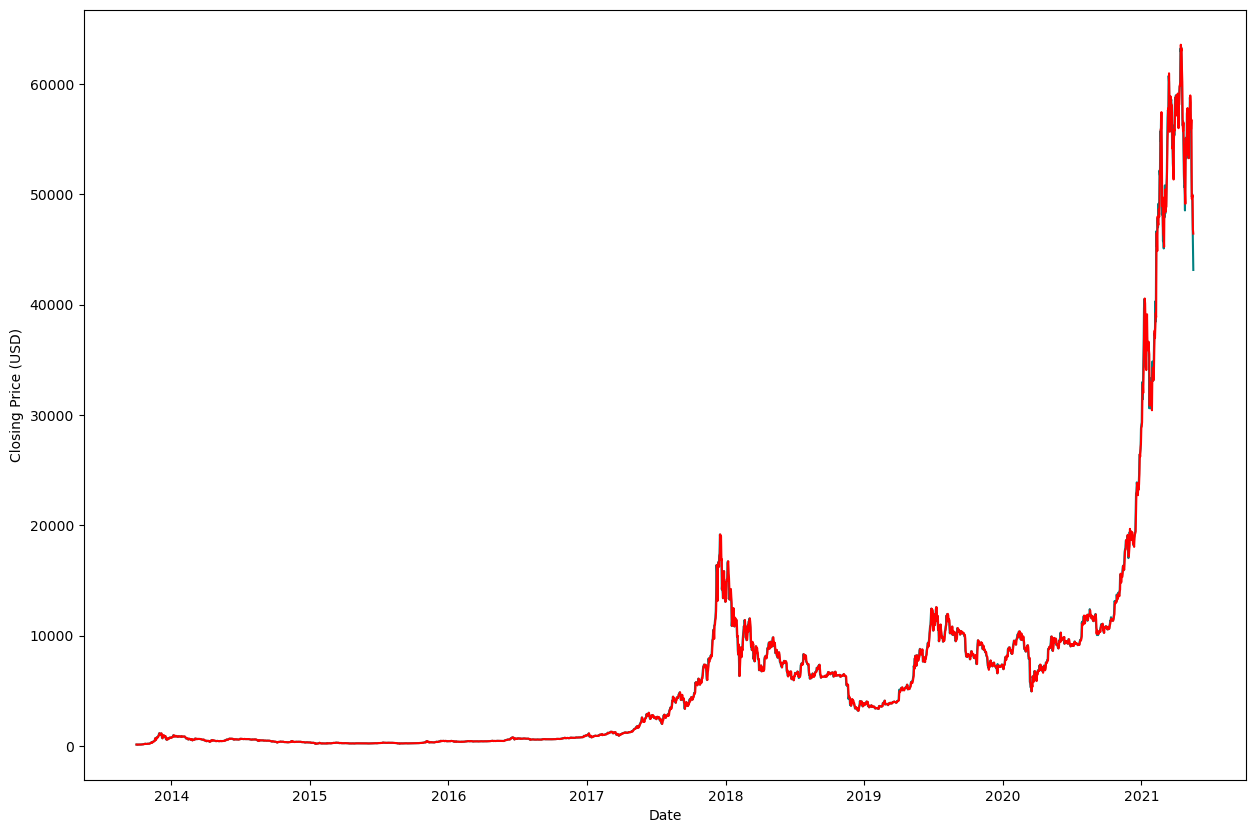

In [7]:
plt.figure(figsize=(15,10))
sns.lineplot(df["Closing Price (USD)"],color="teal")
sns.lineplot(df["24h Open (USD)"],color="red")

<Axes: xlabel='Date', ylabel='24h High (USD)'>

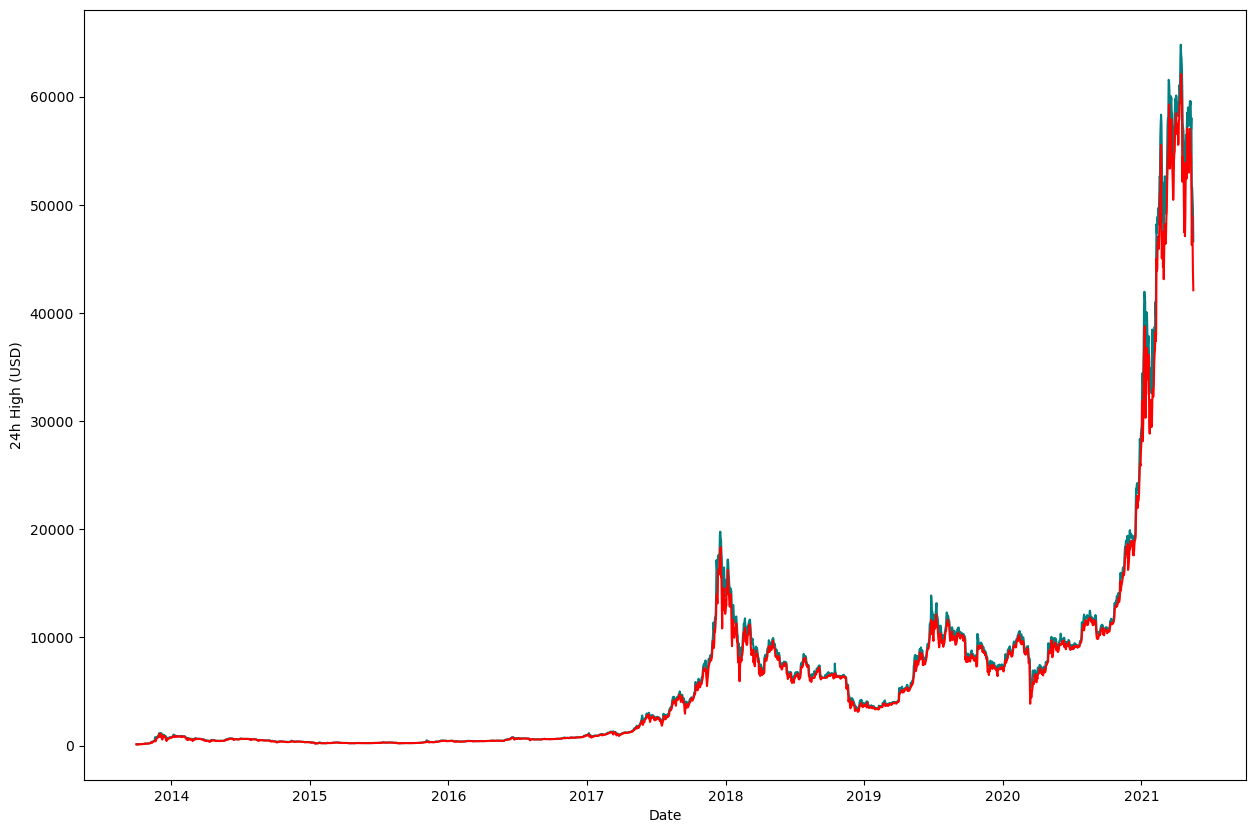

In [8]:
plt.figure(figsize=(15,10))
sns.lineplot(df["24h High (USD)"],color="teal")
sns.lineplot(df["24h Low (USD)"],color="red")

In [31]:
bitcoin = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)":"Price"})
bitcoin

,Price
Date,
2013-10-01,123.654990
2013-10-02,125.455000
2013-10-03,108.584830
2013-10-04,118.674660
2013-10-05,121.338660
...,...
2021-05-14,49764.132082
2021-05-15,50032.693137
2021-05-16,47885.625255


<Axes: xlabel='Date'>

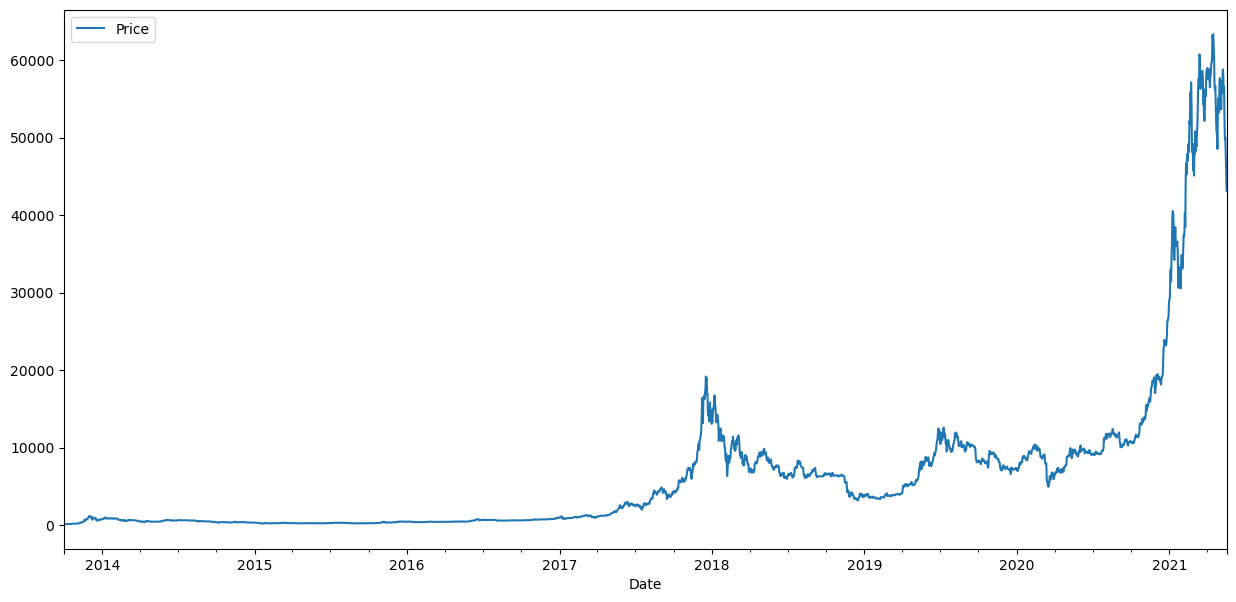

In [32]:
bitcoin.plot(figsize=(15,7))

In [33]:
import csv
from datetime import datetime

timesteps = []
btc_price = []
with open("BTC-USD(3).csv","r") as f:
    csv_reader = csv.reader(f,delimiter=",")
    next(csv_reader) #skips column title
    for line in csv_reader:
        timesteps.append(datetime.strptime(line[0], "%Y-%m-%d"))
        btc_price.append(float(line[4]))

In [34]:
timesteps[:10]

[datetime.datetime(2014, 9, 17, 0, 0),
 datetime.datetime(2014, 9, 18, 0, 0),
 datetime.datetime(2014, 9, 19, 0, 0),
 datetime.datetime(2014, 9, 20, 0, 0),
 datetime.datetime(2014, 9, 21, 0, 0),
 datetime.datetime(2014, 9, 22, 0, 0),
 datetime.datetime(2014, 9, 23, 0, 0),
 datetime.datetime(2014, 9, 24, 0, 0),
 datetime.datetime(2014, 9, 25, 0, 0),
 datetime.datetime(2014, 9, 26, 0, 0)]

In [35]:
btc_price[:10]

[457.334015,
 424.440002,
 394.79599,
 408.903992,
 398.821014,
 402.152008,
 435.790985,
 423.204987,
 411.574005,
 404.424988]

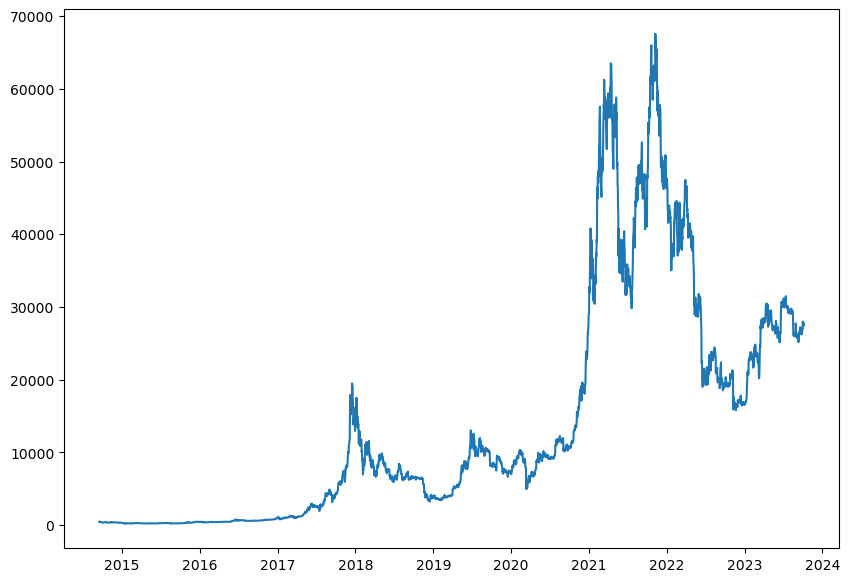

In [36]:
plt.figure(figsize=(10,7))
plt.plot(timesteps,btc_price)

## Train and test splits

In [37]:
timesteps = bitcoin.index.to_numpy()
prices = bitcoin["Price"].to_numpy()

split_size = int(0.8*len(prices))
X_train, y_train = timesteps[:split_size],prices[:split_size]

X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2229, 558, 2229, 558)

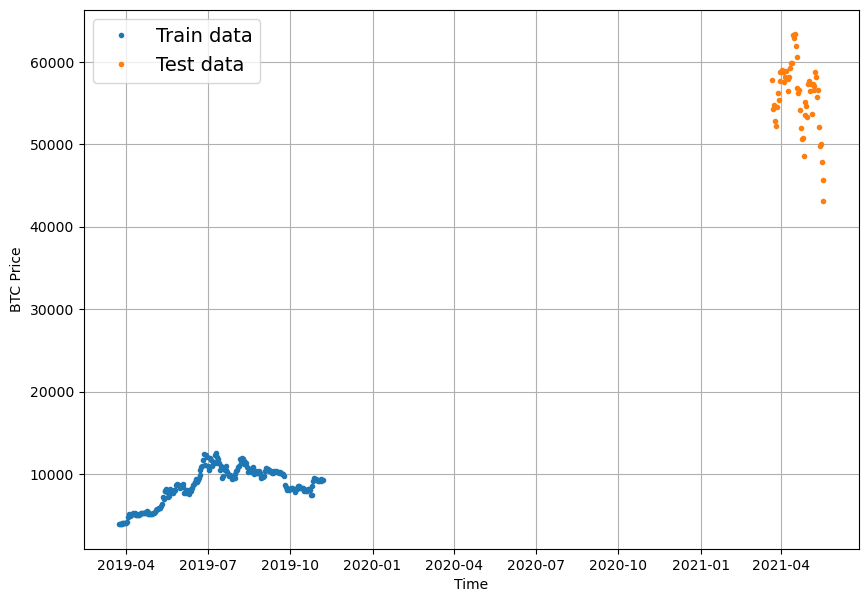

In [43]:
def plot_time_series(timesteps, values, format=".", start=0, end=None, label=None):
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14) # make label bigger
  plt.grid(True)

plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")
     

## MODEL 0 
**NAIVE MODEL**
[BASELINE]
* window = 1 
* horizon = 1

In [44]:
#CREATE A NAIVE FORECAST
naive_forecast = y_test[:-1]

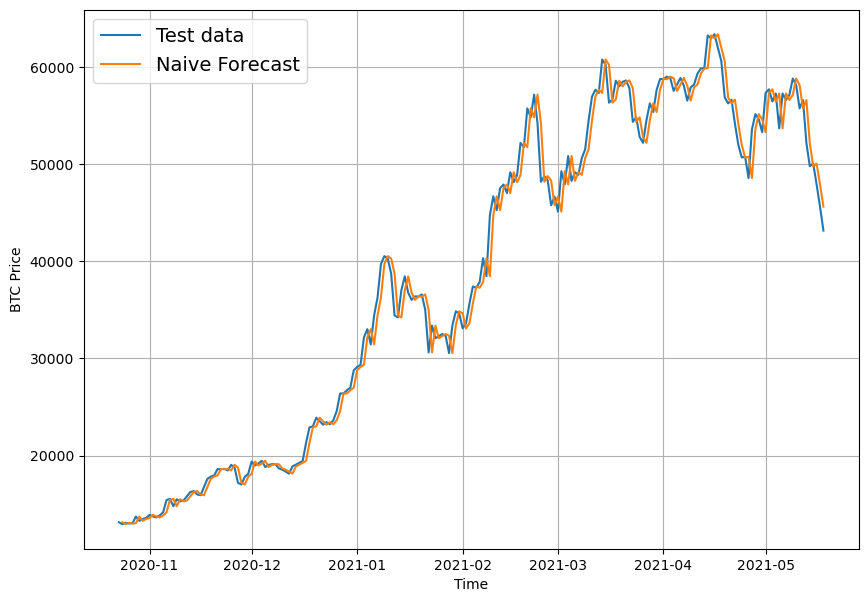

In [45]:
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_test, values=y_test, start=350, format="-", label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, start=350, format="-", label="Naive Forecast")

In [46]:
import tensorflow as tf
     

# MASE implementation
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true-y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shift of 1)

  return mae / mae_naive_no_season
     
def evaluate_preds(y_true, y_pred):
  # Make sure float32 datatype (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various evaluation metrics 
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [47]:
mean_absolute_scaled_error(y_true=y_test[1:], y_pred=naive_forecast).numpy()

0.9995699939182626

In [48]:
naive_results = evaluate_preds(y_true=y_test[1:],
                               y_pred=naive_forecast)

naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.5165248,
 'mase': 0.99957}

In [50]:
# WINDOWING OUR DATASET

HORIZON = 1
WINDOW_SIZE = 7

In [51]:
def get_labelled_window(x, horizon=HORIZON):
    return x[:,:-horizon],x[:,-horizon:]

In [54]:
test_window, test_label = get_labelled_window(tf.expand_dims(tf.range(8)+1,axis=0))
print(f"Window : {tf.squeeze(test_window)} -> label : {tf.squeeze(test_label)}")

Window : [1 2 3 4 5 6 7] -> label : 8


In [64]:
def make_windows(x,window_size=WINDOW_SIZE,horizon=HORIZON):
    
    window_step = np.expand_dims(np.arange(window_size+horizon),axis=0)
    window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)),axis=0).T
    #print(f"Window indexes:\n{window_indexes, window_indexes.shape}")
    
    windowed_array = x[window_indexes]
    
    windows, labels = get_labelled_window(windowed_array)
    return windows, labels

In [66]:
full_windows, full_labels = make_windows(prices)
len(full_windows), len(full_labels)

(2780, 2780)

In [67]:
len(prices)

2787

In [71]:
for i in range(3):
    print(f"Window: {full_windows[i-1]} -> label: {full_labels[i-1]}")

Window: [55715.54665129 56573.5554719  52147.82118698 49764.1320816
 50032.69313676 47885.62525472 45604.61575361] -> label: [43144.47129086]
Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> label: [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> label: [124.049]


In [76]:
def make_train_test_splits(windows, labels, test_split=0.2):
    split_size = int(len(windows)*(1-test_split))
    train_window = windows[:split_size]
    train_label = labels[:split_size]
    test_window = windows[split_size:]
    test_label = labels[split_size:]
    return train_window, test_window, train_label, test_label

In [77]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows,full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [84]:
import os

def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                            monitor="val_loss",
                                            verbose=0, 
                                            save_best_only=True)

## MODEL 1
**DENSE MODEL**
* WINDOW = 7
* HORIZON = 1

In [85]:
import tensorflow as tf
from tensorflow.keras import layers

tf.random.set_seed(42)

In [179]:
model_1 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON, activation="linear")
], name="model_1_dense")

model_1.compile(loss="mae",
               optimizer = tf.keras.optimizers.Adam(),
               metrics=["mae","mse"])

model_1.fit(x=train_windows,y=train_labels,epochs=100,verbose=0,batch_size=128,validation_data=(test_windows,test_labels)
           ,callbacks=[create_model_checkpoint(model_name=model_1.name)])

INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_1_dense\assets


In [180]:
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 1ms/step - loss: 592.2921 - mae: 592.2921 - mse: 1207633.7500


[592.2920532226562, 592.2920532226562, 1207633.75]

In [181]:
model_1 = tf.keras.models.load_model("model_experiments/model_1_dense/")
model_1.evaluate(test_windows,test_labels)

18/18 [==============================] - 0s 1ms/step - loss: 567.7518 - mae: 567.7518 - mse: 1164246.7500


[567.7517700195312, 567.7517700195312, 1164246.75]

In [182]:
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.5165248,
 'mase': 0.99957}

In [183]:
def make_preds(model, input_data):
    forecast = model.predict(input_data)
    return tf.squeeze(forecast)

In [184]:
model_1_preds = make_preds(model_1,test_windows)
len(model_1_preds),model_1_preds[:10]

18/18 [==============================] - 0s 871us/step


(556,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8852.81 , 8765.067, 9030.413, 8775.169, 8711.666, 8740.271,
        8696.057, 8488.305, 8463.789, 8521.927], dtype=float32)>)

In [185]:
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels),y_pred=model_1_preds)

In [186]:
model_1_results

{'mae': 567.7517,
 'mse': 1164246.8,
 'rmse': 1079.0027,
 'mape': 2.5323603,
 'mase': 0.9973825}

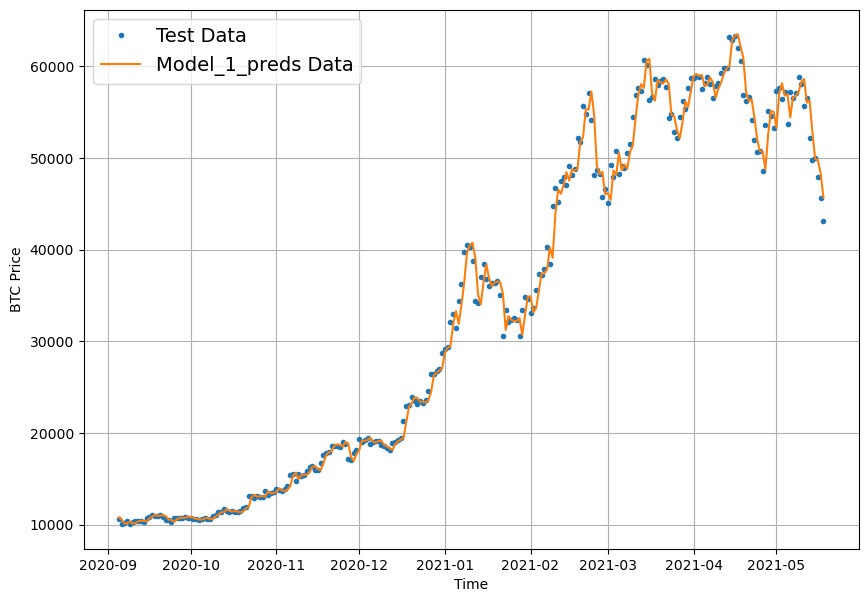

In [187]:
offset=300
plt.figure(figsize=(10,7))

plot_time_series(timesteps=X_test[-len(test_windows):],values=test_labels[:,0],start=offset,label="Test Data")
plot_time_series(timesteps=X_test[-len(test_windows):],values=model_1_preds,start=offset,format="-",label="Model_1_preds Data")

## Model 2
### **Dense** 
* window = 30 
* horizon = 1

In [216]:
WINDOW_SIZE=30
HORIZON=1
full_windows_2, full_labels_2 = make_windows(prices,window_size=30)
len(full_windows_2), len(full_labels_2)

(2757, 2757)

In [217]:
train_windows_2, test_windows_2, train_labels_2, test_labels_2 = make_train_test_splits(full_windows_2,full_labels_2)
len(train_windows_2), len(test_windows_2), len(train_labels_2), len(test_labels_2)

(2205, 552, 2205, 552)

In [218]:
import tensorflow as tf
from tensorflow.keras import layers

tf.random.set_seed(42)

In [238]:
model_2 = tf.keras.Sequential([
    layers.Dense(256, activation="relu"),
    layers.Dense(HORIZON, activation="linear")
], name="model_2_dense")

model_2.compile(loss="mae",
               optimizer = tf.keras.optimizers.Adam(),
               metrics=["mae","mse"])

model_2.fit(x=train_windows_2,y=train_labels_2,epochs=300,verbose=0,batch_size=256,validation_data=(test_windows_2,test_labels_2)
           ,callbacks=[create_model_checkpoint(model_name=model_2.name)])

INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets


In [239]:
model_2_1 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON, activation="linear")
], name="model_2_1_dense")

model_2_1.compile(loss="mae",
               optimizer = tf.keras.optimizers.Adam(),
               metrics=["mae","mse"])

model_2_1.fit(x=train_windows_2,y=train_labels_2,epochs=300,verbose=0,batch_size=256,validation_data=(test_windows_2,test_labels_2)
           ,callbacks=[create_model_checkpoint(model_name=model_2_1.name)])

INFO:tensorflow:Assets written to: model_experiments\model_2_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_1_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_2_1_dense\assets


In [240]:
model_2_1.evaluate(test_windows_2, test_labels_2)

18/18 [==============================] - 0s 1ms/step - loss: 643.6249 - mae: 643.6249 - mse: 1337174.3750


[643.6249389648438, 643.6249389648438, 1337174.375]

In [241]:
model_2_1 = tf.keras.models.load_model("model_experiments/model_2_1_dense/")
model_2_1.evaluate(test_windows_2,test_labels_2)

18/18 [==============================] - 0s 1ms/step - loss: 585.7063 - mae: 585.7063 - mse: 1222751.8750


[585.706298828125, 585.706298828125, 1222751.875]

In [248]:
model_2_1_preds = make_preds(model_2_1,test_windows_2)
#len(model_2_preds),model_2_preds[:10]
model_2_1_results = evaluate_preds(y_true=tf.squeeze(test_labels_2),y_pred=model_2_1_preds)
model_2_1_results

18/18 [==============================] - 0s 862us/step


{'mae': 585.7062,
 'mse': 1222751.8,
 'rmse': 1105.781,
 'mape': 2.6636825,
 'mase': 1.0238202}

In [249]:
model_2.evaluate(test_windows_2, test_labels_2)

18/18 [==============================] - 0s 1ms/step - loss: 587.1904 - mae: 587.1904 - mse: 1182140.2500


[587.1904296875, 587.1904296875, 1182140.25]

In [250]:
model_2 = tf.keras.models.load_model("model_experiments/model_2_dense/")
model_2.evaluate(test_windows_2,test_labels_2)

18/18 [==============================] - 0s 1ms/step - loss: 587.1904 - mae: 587.1904 - mse: 1182140.2500


[587.1904296875, 587.1904296875, 1182140.25]

In [251]:
model_2_preds = make_preds(model_2,test_windows_2)
#len(model_2_preds),model_2_preds[:10]
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels_2),y_pred=model_2_preds)

18/18 [==============================] - 0s 868us/step


In [252]:
model_2_results, model_1_results

({'mae': 587.1904,
  'mse': 1182139.9,
  'rmse': 1087.2626,
  'mape': 2.6648383,
  'mase': 1.0264146},
 {'mae': 567.7517,
  'mse': 1164246.8,
  'rmse': 1079.0027,
  'mape': 2.5323603,
  'mase': 0.9973825})

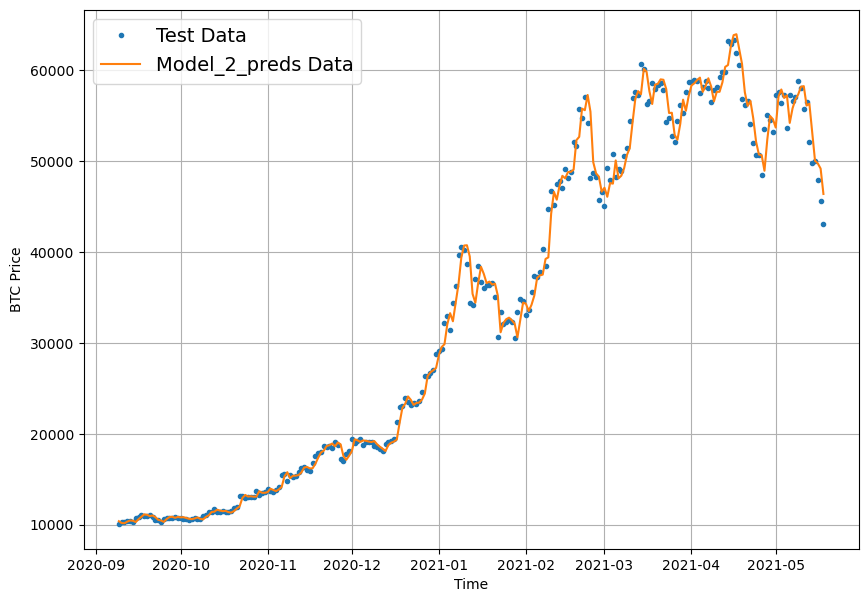

In [247]:
offset=300
plt.figure(figsize=(10,7))

plot_time_series(timesteps=X_test[-len(test_windows_2):],values=test_labels_2[:,0],start=offset,label="Test Data")
plot_time_series(timesteps=X_test[-len(test_windows_2):],values=model_2_preds,start=offset,format="-",label="Model_2_preds Data")

## Model 3
### **Dense** 
* window = 30 
* horizon = 7

In [268]:
HORIZON = 7
WINDOW_SIZE = 30

full_windows, full_labels = make_windows(prices, 30, 7)

In [269]:
len(full_windows),len(full_labels)

(2751, 2751)

In [270]:
train_windows, test_windows, train_labels,test_labels = make_train_test_splits(windows=full_windows,labels=full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2200, 551, 2200, 551)

In [259]:
tf.random.set_seed(42)

model_3 = tf.keras.Sequential([
    layers.Dense(256,activation="relu"),
    layers.Dense(HORIZON)
],name="model_3_dense")

model_3.compile(loss="MAE",
               optimizer = tf.keras.optimizers.Adam())

model_3.fit(train_windows,train_labels,batch_size=256,epochs=100,
           verbose=0,validation_data=(test_windows,test_labels),
           callbacks=[create_model_checkpoint(model_name=model_3.name)])

INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets


In [260]:
model_3.evaluate(test_windows,test_labels)

18/18 [==============================] - 0s 1ms/step - loss: 753.8887


753.8887329101562

In [261]:
model_3 = tf.keras.models.load_model("model_experiments/model_3_dense/")
model_3.evaluate(test_windows,test_labels)

18/18 [==============================] - 0s 1ms/step - loss: 657.7130


657.7130126953125

In [277]:
'''model_3_preds = make_preds(model_3,test_windows)
#len(model_2_preds),model_2_preds[:10]
model_3_results = evaluate_preds(y_true=test_labels,y_pred=model_3_preds)
model_3_results,model_2_results,model_1_results'''

'model_3_preds = make_preds(model_3,test_windows)\n#len(model_2_preds),model_2_preds[:10]\nmodel_3_results = evaluate_preds(y_true=test_labels,y_pred=model_3_preds)\nmodel_3_results,model_2_results,model_1_results'

In [266]:
def evaluate_preds(y_true, y_pred):
    # Make sure float32 datatype (for metric calculations)
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various evaluation metrics 
    mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
    mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
    mase = mean_absolute_scaled_error(y_true, y_pred)

    if mae.ndim > 0:
        mae = tf.reduce_mean(mae)
        mse = tf.reduce_mean(mse)
        rmse = tf.reduce_mean(rmse)
        mape = tf.reduce_mean(mape)
        mase = tf.reduce_mean(mase)

    return {"mae": mae.numpy(),
            "mse": mse.numpy(),
            "rmse": rmse.numpy(),
            "mape": mape.numpy(),
            "mase": mase.numpy()}

In [276]:
model_3_preds = make_preds(model_3,test_windows)
#len(model_2_preds),model_2_preds[:10]
model_3_results = evaluate_preds(y_true=test_labels,y_pred=model_3_preds)
model_3_results,model_2_results,model_1_results

18/18 [==============================] - 0s 988us/step


({'mae': 657.71295,
  'mse': 1439412.2,
  'rmse': 690.8621,
  'mape': 2.9925458,
  'mase': 1.1479393},
 {'mae': 587.1904,
  'mse': 1182139.9,
  'rmse': 1087.2626,
  'mape': 2.6648383,
  'mase': 1.0264146},
 {'mae': 567.7517,
  'mse': 1164246.8,
  'rmse': 1079.0027,
  'mape': 2.5323603,
  'mase': 0.9973825})

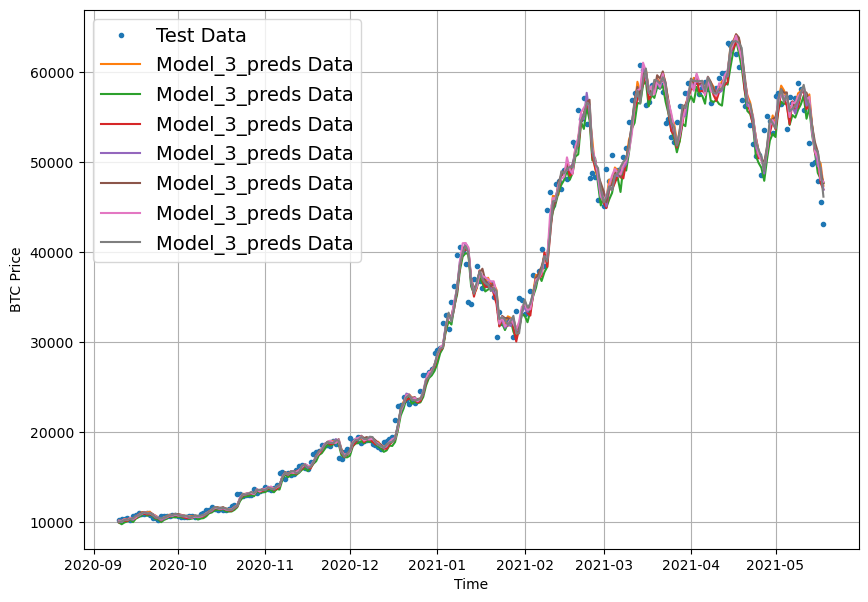

In [278]:
offset=300
plt.figure(figsize=(10,7))

plot_time_series(timesteps=X_test[-len(test_windows):],values=test_labels[:,0],start=offset,label="Test Data")
plot_time_series(timesteps=X_test[-len(test_windows):],values=model_3_preds,start=offset,format="-",label="Model_3_preds Data")

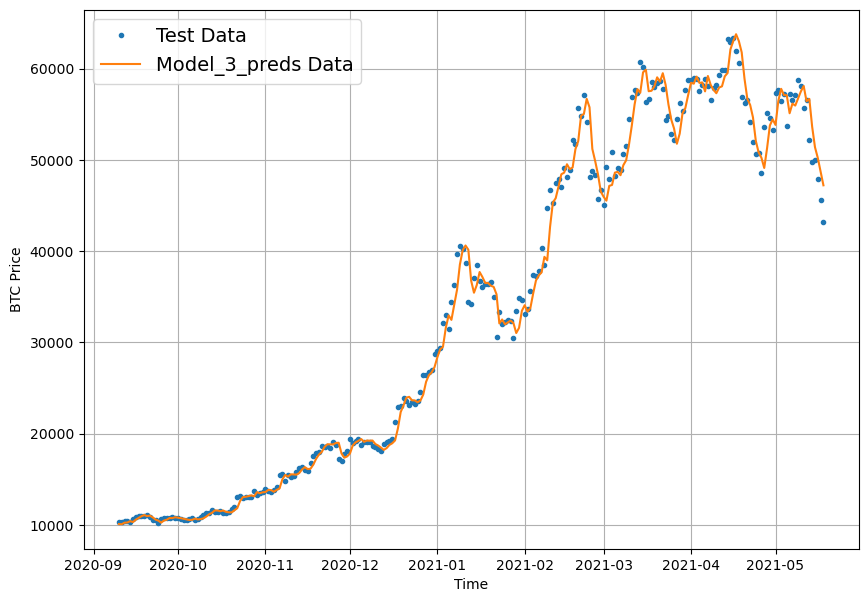

In [281]:
offset=300
plt.figure(figsize=(10,7))

plot_time_series(timesteps=X_test[-len(test_windows):],values=test_labels[:,0],start=offset,label="Test Data")
plot_time_series(timesteps=X_test[-len(test_windows):],values=tf.reduce_mean(model_3_preds,axis=1),start=offset,format="-",label="Model_3_preds Data")

<Axes: >

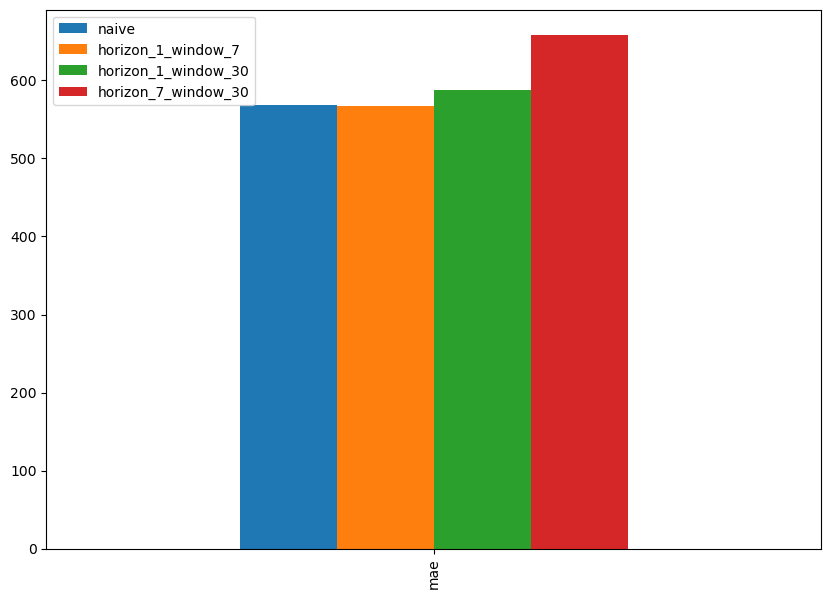

In [283]:

pd.DataFrame({"naive": naive_results["mae"],
              "horizon_1_window_7": model_1_results["mae"],
              "horizon_1_window_30": model_2_results["mae"],
              "horizon_7_window_30": model_3_results["mae"]}, index=["mae"]).plot(figsize=(10, 7), kind="bar")

## Model 4
### **CONV 1D** 
* window = 7 
* horizon = 1

In [284]:
HORIZON=1
WINDOW_SIZE=7

In [285]:
full_windows_4, full_labels_4 = make_windows(prices,WINDOW_SIZE,HORIZON)
len(full_windows_4),len(full_labels_4)

(2780, 2780)

In [286]:
train_windows_4,test_windows_4, train_labels_4, test_labels_4 = make_train_test_splits(full_windows_4,full_labels_4)

In [287]:
len(train_windows_4),len(test_windows_4), len(train_labels_4), len(test_labels_4)

(2224, 556, 2224, 556)

In [289]:
train_windows_4[0].shape

(7,)

In [290]:
x = tf.constant(train_windows_4[0])
x

<tf.Tensor: shape=(7,), dtype=float64, numpy=
array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
       121.795  ])>

In [291]:
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x,axis=1))

In [292]:
print(f"OG : {x.shape}")
print(f"expanded shape : {expand_dims_layer(x).shape}")
print(f"expanded : {expand_dims_layer(x)}")

OG : (7,)
expanded shape : (7, 1)
expanded : [[123.65499]
 [125.455  ]
 [108.58483]
 [118.67466]
 [121.33866]
 [120.65533]
 [121.795  ]]


In [295]:
tf.random.set_seed(42)

model_4 = tf.keras.Sequential([
    layers.Lambda(lambda x: tf.expand_dims(x,axis=1)),
    layers.Conv1D(filters=128, kernel_size=5, strides=1, padding = "causal",activation="relu"),
    layers.Dense(HORIZON)
],name="model_4_Conv1D")

model_4.compile(loss="mae",optimizer=tf.keras.optimizers.Adam()
               )

model_4.fit(train_windows_4,train_labels_4, batch_size=256, epochs=200,
           verbose=0,validation_data=(test_windows_4,test_labels_4),
           callbacks=[create_model_checkpoint(model_name=model_4.name)])

INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


In [296]:
model_4.evaluate(test_windows_4,test_labels_4)

18/18 [==============================] - 0s 2ms/step - loss: 566.3979


566.3978881835938

In [299]:
model_4 = tf.keras.models.load_model("model_experiments/model_4_Conv1D/")
model_4.evaluate(test_windows_4,test_labels_4)

18/18 [==============================] - 0s 1ms/step - loss: 566.2036


566.2035522460938

In [301]:
model_4_preds = make_preds(model_4,test_windows_4)
#len(model_2_preds),model_2_preds[:10]
model_4_results = evaluate_preds(y_true=tf.squeeze(test_labels_4),y_pred=model_4_preds)
model_4_results,model_2_results,model_1_results

18/18 [==============================] - 0s 939us/step


({'mae': 566.2036,
  'mse': 1173728.2,
  'rmse': 1083.3875,
  'mape': 2.5396905,
  'mase': 0.99466294},
 {'mae': 587.1904,
  'mse': 1182139.9,
  'rmse': 1087.2626,
  'mape': 2.6648383,
  'mase': 1.0264146},
 {'mae': 567.7517,
  'mse': 1164246.8,
  'rmse': 1079.0027,
  'mape': 2.5323603,
  'mase': 0.9973825})